In [1]:

!pip install pandas

/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_84252/433472611.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = data = {f.split("/")[-1].replace(".txt", "").replace("energies_", ""): pd.read_csv(f, delim_whitespace=True) for f in energy_files}
/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_84252/433472611.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = data = {f.split("/")[-1].replace(".txt", "").replace("energies_", ""): pd.read_csv(f, delim_whitespace=True) for f in energy_files}
/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_84252/433472611.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = data = {f.split("/")[-1].replace(".tx

Detected Active Spaces for Analysis: ['4_10', '4_11', '4_12', '4_13', '4_14', '4_15', '4_16', '4_4', '4_5', '4_6', '4_7', '4_8', '4_9']
Active Space 10 CASCI Errors (First 5): [0.03156100669779871, 0.031179368430349186, 0.030933861257127937, 0.030805308334065806, 0.030764891141569883]
Active Space 10 CASSCF Errors (First 5): [0.000756169594624545, 0.0007614161021347599, 0.0007739447860748427, 0.0007989520847848652, 0.0008301938932060438]
Active Space 11 CASCI Errors (First 5): [0.02705626223495372, 0.02658259967547405, 0.026388049253114332, 0.02642634320331183, 0.026647763319286533]
Active Space 11 CASSCF Errors (First 5): [0.0004315617084067469, 0.00043000128834780327, 0.0004334491760342729, 0.0004442297007143381, 0.0004575825750539053]
Active Space 12 CASCI Errors (First 5): [0.026175979662346194, 0.025807277069408663, 0.025700087150267947, 0.02580946397832129, 0.02608762752416105]
Active Space 12 CASSCF Errors (First 5): [0.00010961430528766414, 0.00010135326020588309, 9.57438043682

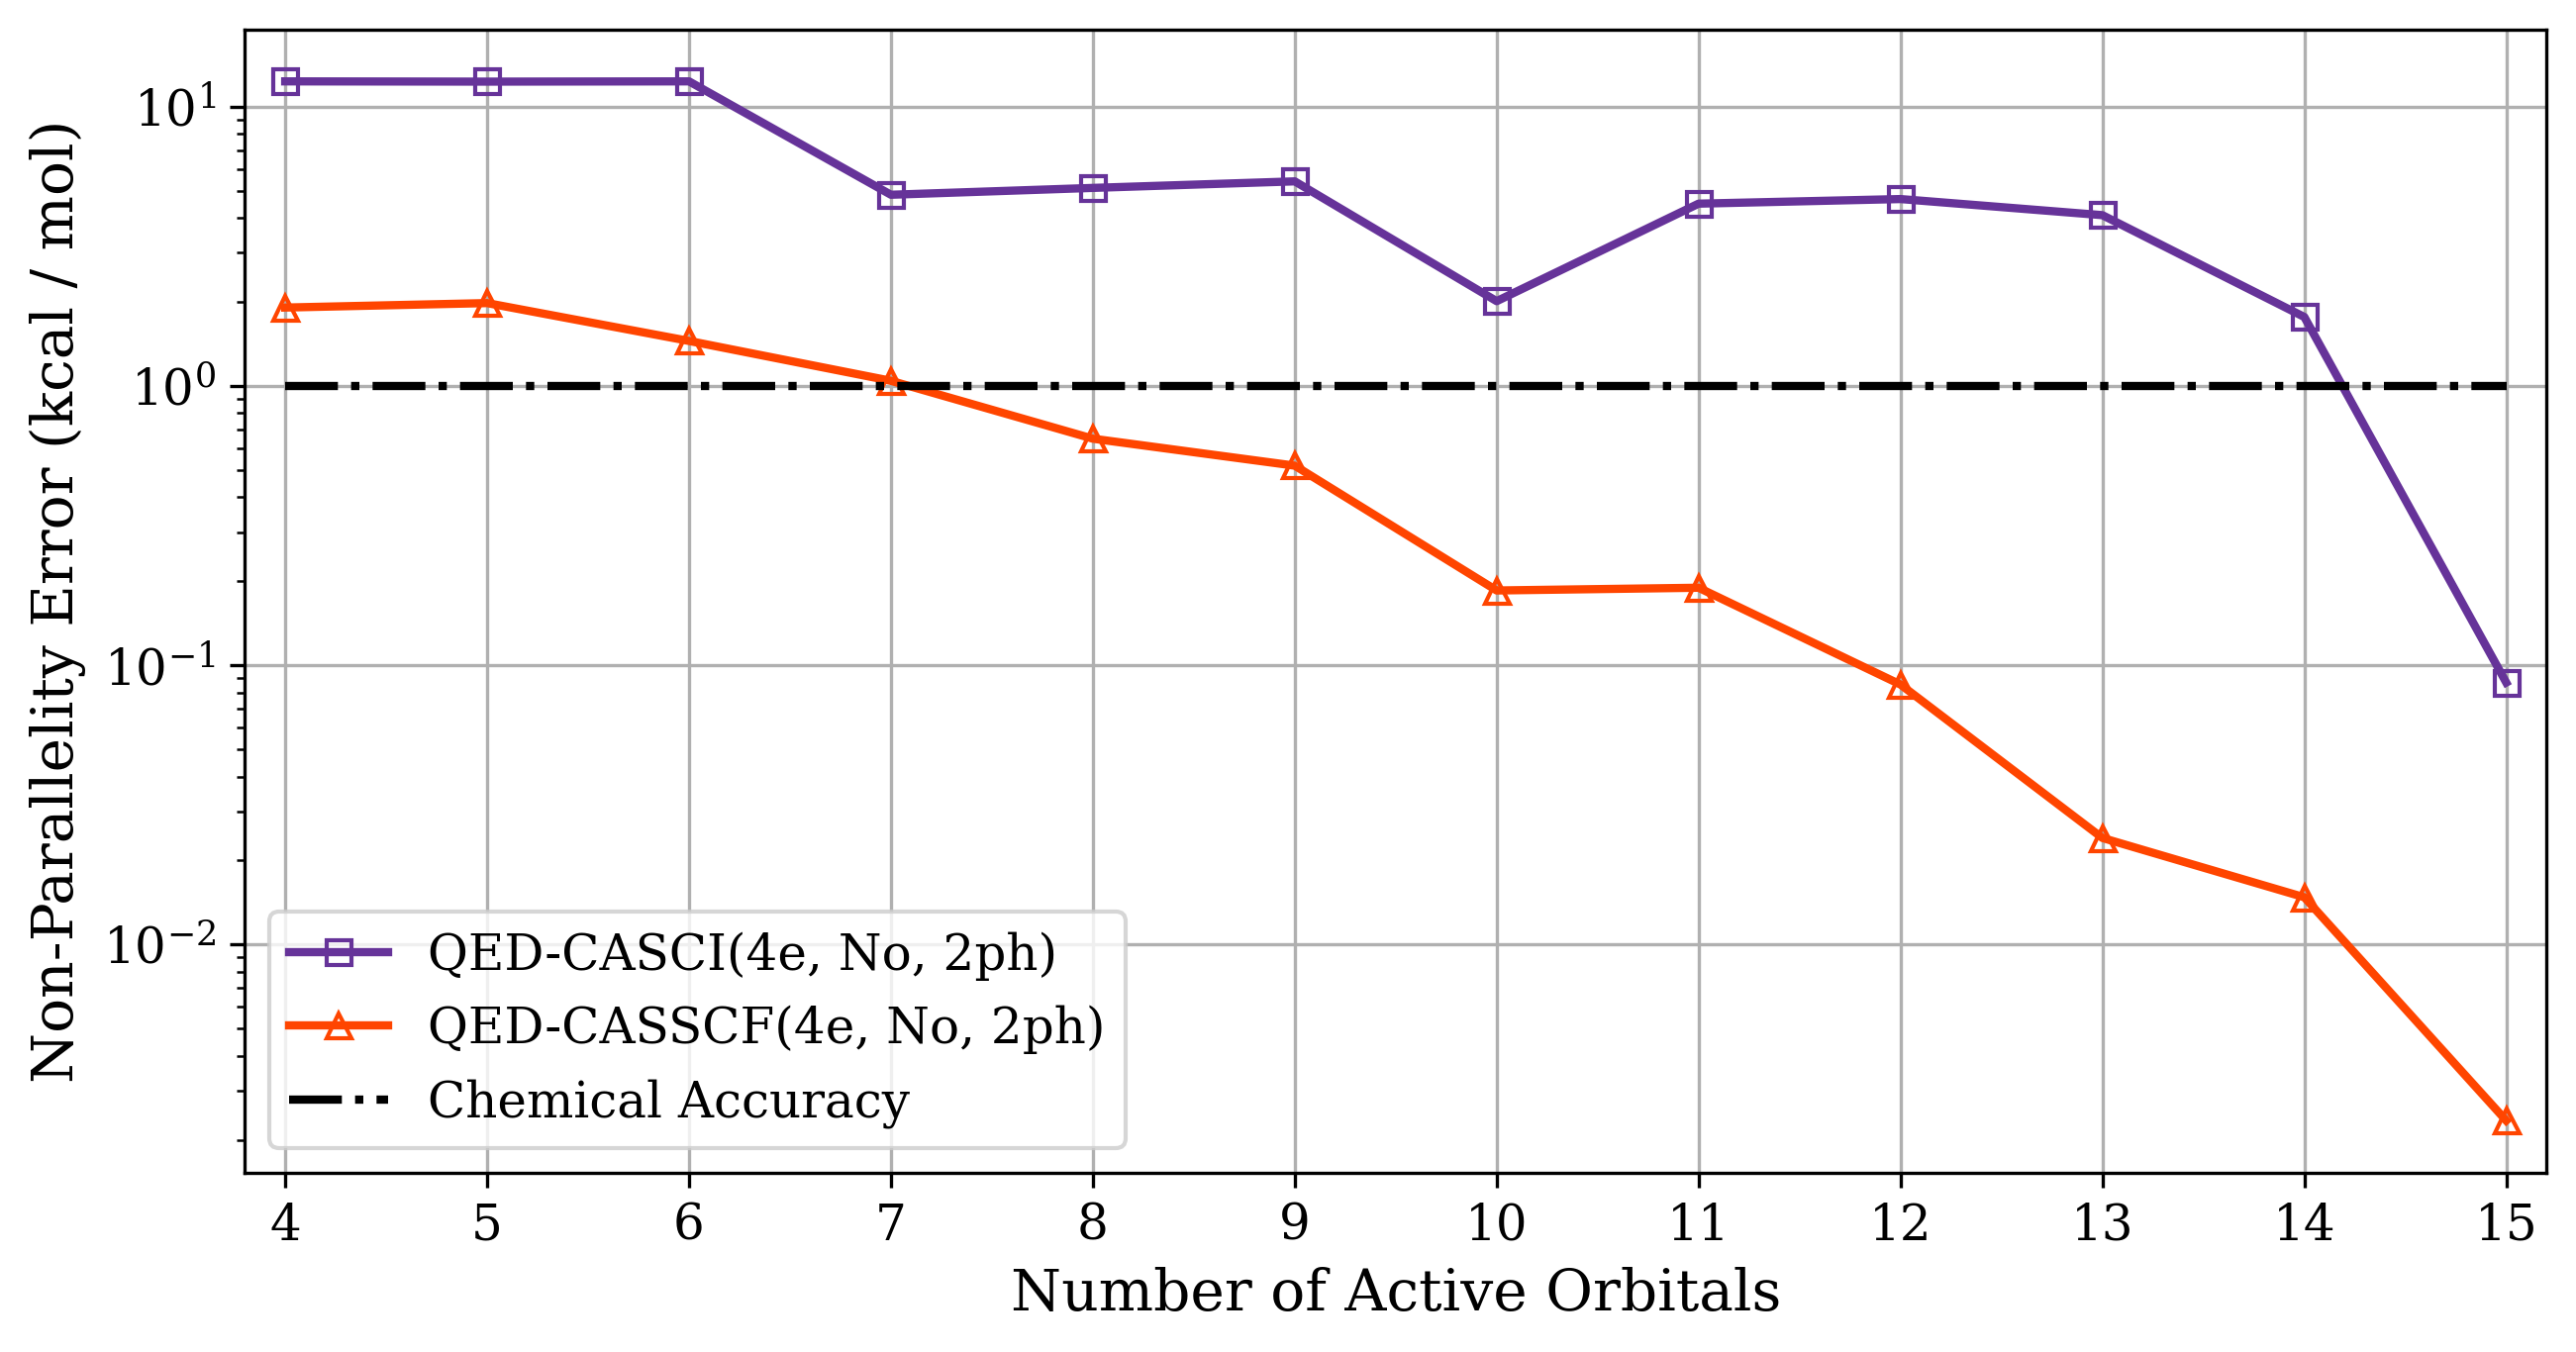

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker  # For better tick formatting
from matplotlib.ticker import FormatStrFormatter
# Use a professional font and improve overall aesthetics
mpl.rcParams.update({
    "text.usetex": False,  # Set to True if using LaTeX rendering
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
    "lines.linewidth": 2,
    "lines.markersize": 6,
})
color3 = "rebeccapurple"
color2 = "salmon"
color1 = "forestgreen"
color4 = "dodgerblue"
color5 = "orangered"
# Define styles
styles = {
    "QED-FCI": {"color": color4, "linestyle": "-", "marker": "o", "markerfacecolor":color4},
    "QED-CASCI": {"color": color3, "linestyle": "-", "marker": "s", "markerfacecolor":"none"},
    "QED-CASSCF": {"color": color5, "linestyle": "-", "marker": "^", "markerfacecolor":"none"},
}

# conversion from Hartree to kcal / mol
au_to_kcal_mol = 627.509474

# 🔹 Change this to your actual path where the files are stored
data_dir = "/Users/jfoley19/Code/data_repository/Mapol/QED-CASSCF_Results/LiH/NPE"  

# Find all active space energy files
energy_files = sorted(glob.glob(os.path.join(data_dir, "energies_4_*")))

# Load all active space data into a dictionary
data = data = {f.split("/")[-1].replace(".txt", "").replace("energies_", ""): pd.read_csv(f, delim_whitespace=True) for f in energy_files}


# Load the reference file (fci_2) which serves as reference for both CASCI & CASSCF
reference_df = pd.read_csv(os.path.join(data_dir, "fci_2"), delim_whitespace=True, names=["Bond Length", "Reference Energy"])
reference_df["Bond Length"] = reference_df["Bond Length"].astype(float)
reference_df = reference_df.set_index("Bond Length")  # Set bond length as index

# Ensure "Bond Length" is float in all active space files and set as index
for active_space in data:
    data[active_space]["Bond Length"] = data[active_space]["Bond Length"].astype(float)
    data[active_space] = data[active_space].set_index("Bond Length")

# ✅ Debugging: Print active spaces detected
print("Detected Active Spaces for Analysis:", list(data.keys()))

# Compute CASCI & CASSCF errors relative to fci_2 reference
casci_errors = {}
casscf_errors = {}

for active_space, df in data.items():
    active_space_number = int(active_space.split("_")[1])  # Extract active space number
    common_bond_lengths = df.index.intersection(reference_df.index)  # Ensure matching bond lengths
    
    casci_diff = df.loc[common_bond_lengths, "CASCI Energy"] - reference_df.loc[common_bond_lengths, "Reference Energy"]
    casscf_diff = df.loc[common_bond_lengths, "CASSCF Energy"] - reference_df.loc[common_bond_lengths, "Reference Energy"]

    casci_errors[active_space_number] = casci_diff  # 🔹 Fix: Store correctly by active space
    casscf_errors[active_space_number] = casscf_diff  # 🔹 Fix: Store correctly by active space

    print(f"Active Space {active_space_number} CASCI Errors (First 5): {casci_errors[active_space_number].head().tolist()}")
    print(f"Active Space {active_space_number} CASSCF Errors (First 5): {casscf_errors[active_space_number].head().tolist()}")

# ✅ Compute NPE for Each Active Space
casci_npe = {}
casscf_npe = {}

for active_space_number, errors in casci_errors.items():
    if len(errors) > 0:  # Ensure we have data
        casci_npe[active_space_number] = np.max(errors) - np.min(errors)

for active_space_number, errors in casscf_errors.items():
    if len(errors) > 0:
        casscf_npe[active_space_number] = np.max(errors) - np.min(errors)

# ✅ Debugging: Print computed NPE values
print("CASCI NPE values:", casci_npe)
print("CASSCF NPE values:", casscf_npe)

# ✅ Ensure all active spaces (4 to 16) are included in the plot
sorted_active_spaces = sorted(set(casci_npe.keys()).union(set(casscf_npe.keys())))

# Extract values for plotting
casci_npe_values = [casci_npe.get(n, 0) for n in sorted_active_spaces]  # Default to 0 if missing
casscf_npe_values = [casscf_npe.get(n, 0) for n in sorted_active_spaces]

# ✅ Print active spaces that are being plotted
num_act = len(sorted_active_spaces)
print("Active Spaces Plotted:", sorted_active_spaces[:num_act-1])

chem_accuracy = np.ones_like(sorted_active_spaces[:num_act-1])

# ✅ Plot NPE vs. Active Space
plt.figure(figsize=(10, 5))
plt.plot(sorted_active_spaces[:num_act-1], np.array(casci_npe_values[:num_act-1]) * au_to_kcal_mol, label="QED-CASCI(4e, No, 2ph)", color= color3, linestyle= "-", marker = "s", markerfacecolor ="none")
plt.plot(sorted_active_spaces[:num_act-1], np.array(casscf_npe_values[:num_act-1]) * au_to_kcal_mol, label="QED-CASSCF(4e, No, 2ph)", color = color5, linestyle = "-", marker = "^", markerfacecolor= "none")
plt.plot(sorted_active_spaces[:num_act-1], chem_accuracy, label="Chemical Accuracy", color = "black", linestyle = "-.")
# Formatting the plot
plt.xticks(sorted_active_spaces)  # Ensure only active space numbers appear
plt.xlabel("Number of Active Orbitals")
plt.ylabel("Non-Parallelity Error (kcal / mol)")
#plt.title("CASCI and CASSCF NPE vs. Active Space")
plt.xlim(3.8,15.2)
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.savefig("NPE_vs_Active_Space.png", dpi=400, bbox_inches="tight")


plt.show()
